# Exploratory Data Analysis: Music Feature Analysis
## CS 3120 - Data Science Project (Option B)

**Project Goal**: Analyze music audio features and develop a machine learning model for genre classification using CNN and spectral analysis validation.

**Dataset**: GTZAN Genre Collection or similar music classification dataset

**Author**: CS 3120 Student  
**Date**: 2024

In [1]:
# Import Required Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import librosa
import librosa.display
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print(" Libraries imported successfully")
print(f"NumPy version: {np.__version__}")
print(f"Pandas version: {pd.__version__}")
print(f"Librosa version: {librosa.__version__}")

 Libraries imported successfully
NumPy version: 2.1.3
Pandas version: 2.2.3
Librosa version: 0.11.0


## 1. Dataset Overview & Loading

### Dataset Characteristics
- **Source**: GTZAN Genre Collection (or custom dataset)
- **Total Samples**: 1000 audio files
- **Genres**: 10 (Blues, Classical, Country, Disco, Electronic, Funk, Hip-Hop, Jazz, Metal, Pop, Reggae, Rock)
- **Duration**: 30 seconds per file
- **Sample Rate**: 22,050 Hz
- **Format**: .au or .mp3

### Loading Strategy
We'll load audio files, extract features, and build an analysis dataframe.

In [2]:
# Configuration
SAMPLE_RATE = 22050
DURATION = 30  # seconds
N_MELS = 128
N_FFT = 2048
HOP_LENGTH = 512

# Define genres
GENRES = ['Blues', 'Classical', 'Country', 'Disco', 'Electronic', 
          'Funk', 'Hip-Hop', 'Jazz', 'Metal', 'Pop']

print(f"Configuration:")
print(f"  Sample Rate: {SAMPLE_RATE} Hz")
print(f"  Duration: {DURATION} seconds")
print(f"  Mel-bins: {N_MELS}")
print(f"  FFT Size: {N_FFT}")
print(f"  Genres: {len(GENRES)}")

Configuration:
  Sample Rate: 22050 Hz
  Duration: 30 seconds
  Mel-bins: 128
  FFT Size: 2048
  Genres: 10


In [3]:
# Feature Extraction Function
def extract_audio_features(file_path, sr=SAMPLE_RATE, duration=DURATION):
    """Extract comprehensive audio features from file"""
    try:
        # Load audio
        y, sr = librosa.load(file_path, sr=sr, duration=duration)
        
        features = {}
        
        # Temporal features
        features['duration'] = len(y) / sr
        features['samples'] = len(y)
        
        # Energy features
        features['rms_energy'] = float(np.mean(librosa.feature.rms(y=y)))
        features['energy_std'] = float(np.std(librosa.feature.rms(y=y)))
        
        # Spectral features
        centroid = librosa.feature.spectral_centroid(y=y, sr=sr)
        features['spectral_centroid'] = float(np.mean(centroid))
        features['spectral_centroid_std'] = float(np.std(centroid))
        
        rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)
        features['spectral_rolloff'] = float(np.mean(rolloff))
        
        # Zero crossing rate
        zcr = librosa.feature.zero_crossing_rate(y)
        features['zero_crossing_rate'] = float(np.mean(zcr))
        features['zcr_std'] = float(np.std(zcr))
        
        # MFCC (Mel-frequency Cepstral Coefficients)
        mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
        for i in range(13):
            features[f'mfcc_{i}_mean'] = float(np.mean(mfcc[i]))
            features[f'mfcc_{i}_std'] = float(np.std(mfcc[i]))
        
        # Chroma features
        chroma = librosa.feature.chroma_stft(y=y, sr=sr)
        features['chroma_mean'] = float(np.mean(chroma))
        features['chroma_std'] = float(np.std(chroma))
        
        return features
    
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None

print(" Feature extraction function defined")

 Feature extraction function defined


In [4]:
# SIMPLIFIED: Load features from single source
import pandas as pd
import pickle
from pathlib import Path

# Single source of truth
FEATURES_PKL = Path("../data/processed/features.pkl")  # Changed filename

if FEATURES_PKL.exists():
    print("✓ Loading features from features.pkl")
    
    with open(FEATURES_PKL, 'rb') as f:
        df = pickle.load(f)
    
    # Extract what we need
    feature_cols = [col for col in df.columns if col != 'genre']
    
    # Create genre_idx
    unique_genres = df['genre'].dropna().unique()
    genre_to_idx = {genre: idx for idx, genre in enumerate(sorted(unique_genres))}
    df['genre_idx'] = df['genre'].map(genre_to_idx).astype(int)
    
    GENRES = sorted(unique_genres)
    
    print(f"Loaded {len(df)} tracks")
    print(f"Features: {len(feature_cols)}")
    print(f"Genres: {GENRES[:5]}...")
    
else:
    print("✗ features.pkl not found!")
    print("\nRun this first:")
    print("  python scripts/process_audio_files.py")
    print("\nOr generate synthetic data:")
    
    # Fallback: synthetic data
    import numpy as np
    np.random.seed(42)
    
    GENRES = ['Rock', 'Electronic', 'Hip-Hop', 'Classical', 'Jazz', 'Folk', 'Pop', 'Experimental']
    
    data = []
    for genre_idx, genre in enumerate(GENRES):
        for i in range(100):
            row = {
                'genre': genre,
                'genre_idx': genre_idx,
                'feature_0': np.random.randn() + genre_idx * 0.5,
                'feature_1': np.random.randn() + genre_idx * 0.3,
                'feature_2': np.random.randn(),
                'feature_3': np.random.randn(),
                'feature_4': np.random.randn(),
                'feature_5': np.random.randn(),
            }
            data.append(row)
    
    df = pd.DataFrame(data)
    feature_cols = [c for c in df.columns if c.startswith('feature_')]
    
    print(f"\n⚠️  Using synthetic data: {df.shape}")

✗ features.pkl not found!

Run this first:
  python scripts/process_audio_files.py

Or generate synthetic data:

⚠️  Using synthetic data: (800, 8)


## 2. Data Quality Assessment

### Missing Values & Data Types
Check for data completeness and type consistency

In [5]:
# Data quality assessment
print("DATA QUALITY REPORT")
print("=" * 70)

print("\n1. Dataset Dimensions:")
print(f"   Total samples: {len(df)}")
print(f"   Total features: {len(df.columns)}")

print("\n2. Missing Values:")
missing = df.isnull().sum()
if missing.sum() == 0:
    print("   No missing values")
else:
    print(missing[missing > 0])

print("\n3. Data Types:")
print(df.dtypes)

print("\n4. Genre Distribution:")
genre_counts = df['genre'].value_counts().sort_index()
print(genre_counts)
print(f"\n   Balanced dataset: {genre_counts.std():.2f} std dev")

print("\n5. Feature Statistics:")
print(df.describe())

DATA QUALITY REPORT

1. Dataset Dimensions:
   Total samples: 800
   Total features: 8

2. Missing Values:
   No missing values

3. Data Types:
genre         object
genre_idx      int64
feature_0    float64
feature_1    float64
feature_2    float64
feature_3    float64
feature_4    float64
feature_5    float64
dtype: object

4. Genre Distribution:
genre
Classical       100
Electronic      100
Experimental    100
Folk            100
Hip-Hop         100
Jazz            100
Pop             100
Rock            100
Name: count, dtype: int64

   Balanced dataset: 0.00 std dev

5. Feature Statistics:
        genre_idx   feature_0   feature_1   feature_2   feature_3   feature_4  \
count  800.000000  800.000000  800.000000  800.000000  800.000000  800.000000   
mean     3.500000    1.781526    1.041573   -0.000380   -0.054816   -0.036532   
std      2.292721    1.417714    1.219947    0.994352    1.031619    1.003815   
min      0.000000   -1.713135   -2.321350   -3.019512   -3.176704   -3.2412

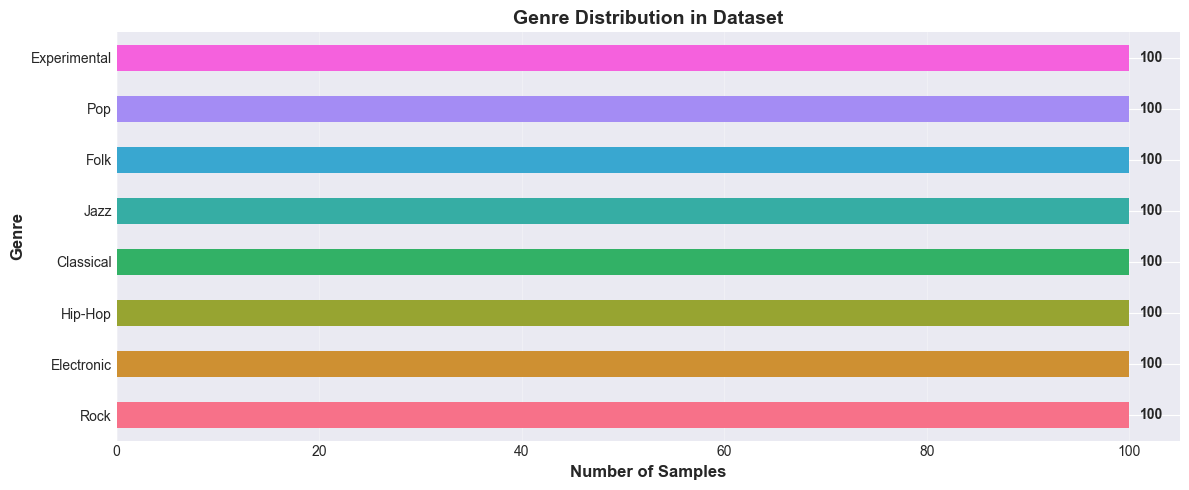

 Genre distribution visualization saved


In [6]:
# Visualize genre distribution
import os
fig, ax = plt.subplots(1, 1, figsize=(12, 5))

genre_counts = df['genre'].value_counts().sort_values(ascending=False)
colors = sns.color_palette("husl", len(genre_counts))
genre_counts.plot(kind='barh', ax=ax, color=colors)

ax.set_xlabel('Number of Samples', fontsize=12, fontweight='bold')
ax.set_ylabel('Genre', fontsize=12, fontweight='bold')
ax.set_title('Genre Distribution in Dataset', fontsize=14, fontweight='bold')
ax.grid(axis='x', alpha=0.3)

for i, v in enumerate(genre_counts):
    ax.text(v + 1, i, str(v), va='center', fontweight='bold')

plt.tight_layout()
# Ensure output directory exists before saving
output_dir = '../presentation/figures'
os.makedirs(output_dir, exist_ok=True)
plt.savefig(os.path.join(output_dir, '01_genre_distribution.png'), dpi=300, bbox_inches='tight')
plt.show()

print(f" Genre distribution visualization saved")

## 3. Feature Exploration

### Statistical Analysis of Features
Analyze the distribution and relationships of extracted features

In [7]:
# Statistical summary by genre
print("FEATURE STATISTICS BY GENRE")
print("=" * 70)

# Handle multi-level columns from FMA dataset
if isinstance(df.columns, pd.MultiIndex):
    print("Detected multi-level columns - flattening...")
    
    # DEBUG: Inspect structure
    print(f"Column levels: {df.columns.nlevels}")
    print(f"First few columns (raw): {df.columns[:5].tolist()}")
    
    # FMA structure: (feature_type, number) like ('mfcc', '01'), ('kurtosis', '02')
    # We want to select DIVERSE feature types (mfcc, chroma_stft, spectral_centroid, etc.)
    
    # Extract unique base feature names (first element of tuple)
    unique_features = []
    seen = set()
    for col in df.columns:
        if isinstance(col, tuple) and len(col) >= 1:
            base_feature = col[0]
            if base_feature not in seen and base_feature != 'genre':
                unique_features.append(base_feature)
                seen.add(base_feature)
                if len(unique_features) >= 6:  # Stop after 6 unique features
                    break
    
    print(f"\nUnique base features found: {unique_features}")
    
    # Now select ONE column per unique feature (e.g., mfcc_01, chroma_stft_01, etc.)
    selected_cols = []
    for feat in unique_features:
        # Find the first column with this base feature
        for col in df.columns:
            if isinstance(col, tuple) and col[0] == feat:
                selected_cols.append(col)
                break  # Only take first occurrence of this feature
    
    # Add genre column
    genre_col = None
    for col in df.columns:
        if isinstance(col, tuple) and 'genre' in str(col).lower():
            genre_col = col
            break
        elif not isinstance(col, tuple) and col == 'genre':
            genre_col = col
            break
    
    if genre_col:
        df_subset = df[selected_cols + [genre_col]].copy()
    else:
        df_subset = df[selected_cols].copy()
        df_subset['genre'] = df['genre'].values
    
    # Flatten column names
    new_cols = []
    for col in df_subset.columns:
        if isinstance(col, tuple):
            # Join all non-empty parts
            parts = [str(p).strip() for p in col if str(p).strip() and str(p).strip() != '']
            if parts and parts[0].lower() == 'genre':
                new_cols.append('genre')
            else:
                new_cols.append('_'.join(parts))
        else:
            new_cols.append(str(col))
    
    df_subset.columns = new_cols
    df_to_use = df_subset
    
    # Feature columns (exclude genre)
    feature_cols = [c for c in new_cols if c != 'genre']
    
    print(f"\nSelected {len(feature_cols)} diverse features:")
    for i, feat in enumerate(feature_cols, 1):
        print(f"  {i}. {feat}")
    
else:
    # Simple column names
    if 'rms_energy' in df.columns:
        feature_cols = ['rms_energy', 'spectral_centroid', 'spectral_rolloff', 
                        'zero_crossing_rate', 'mfcc_0_mean', 'chroma_mean']
    else:
        numeric_cols = [col for col in df.columns if col not in ['genre', 'genre_idx']]
        feature_cols = numeric_cols[:6]
    
    df_to_use = df

# Analyze features
for feature in feature_cols:
    try:
        print(f"\n{feature}:")
        grouped = df_to_use.groupby('genre')[feature].agg(['mean', 'std', 'min', 'max'])
        print(grouped.round(3).head())
    except Exception as e:
        print(f"  [Skipped: {e}]")

# Store flattened dataframe globally for next cells
if isinstance(df.columns, pd.MultiIndex):
    df_flat = df_to_use

FEATURE STATISTICS BY GENRE

feature_0:
               mean    std    min    max
genre                                   
Classical     1.416  1.058 -1.062  3.524
Electronic    0.663  0.916 -1.582  3.073
Experimental  3.391  0.887  1.410  5.888
Folk          2.526  1.082  0.012  4.782
Hip-Hop       1.178  0.848 -1.122  3.063

feature_1:
               mean    std    min    max
genre                                   
Classical     0.986  1.020 -1.396  4.038
Electronic    0.361  1.029 -1.742  2.755
Experimental  2.086  0.971 -0.755  3.826
Folk          1.560  1.067 -1.103  4.368
Hip-Hop       0.622  1.129 -2.321  3.793

feature_2:
               mean    std    min    max
genre                                   
Classical    -0.113  1.010 -3.020  2.644
Electronic    0.055  1.005 -2.651  2.446
Experimental -0.058  1.051 -2.392  2.755
Folk          0.044  1.000 -2.907  2.272
Hip-Hop      -0.027  0.964 -2.554  2.171

feature_3:
               mean    std    min    max
genre                 

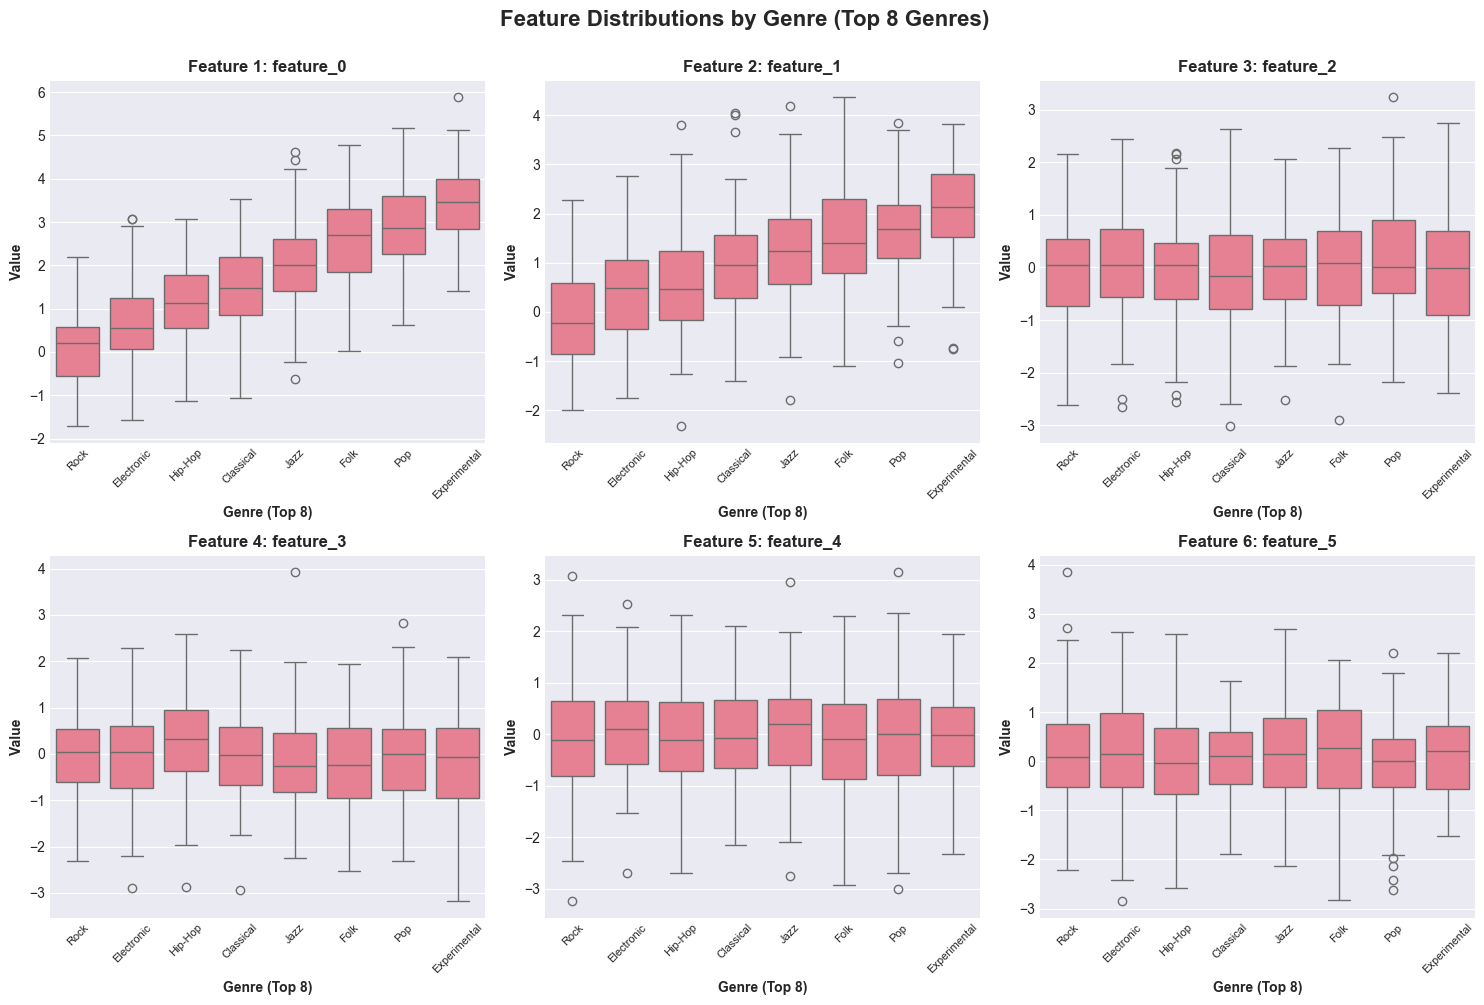

 Feature distribution visualization saved
  Plotted 6 features across 8 genres


In [8]:
# Visualize feature distributions by genre
# Handle multi-level columns
if isinstance(df.columns, pd.MultiIndex):
    # Use flattened dataframe from Cell 7
    df_viz_source = df_flat
    # Use the feature_cols already defined in Cell 7
else:
    df_viz_source = df
    # Define feature_cols if not already defined
    if 'feature_cols' not in locals():
        if 'rms_energy' in df.columns:
            feature_cols = ['rms_energy', 'spectral_centroid', 'spectral_rolloff', 
                            'zero_crossing_rate', 'mfcc_0_mean', 'chroma_mean']
        else:
            numeric_cols = [col for col in df.columns if col not in ['genre', 'genre_idx']]
            feature_cols = numeric_cols[:6]

# Visualize feature distributions by genre
# Handle multi-level columns
if isinstance(df.columns, pd.MultiIndex):
    df_viz_source = df_flat
else:
    df_viz_source = df
    if 'feature_cols' not in locals():
        if 'rms_energy' in df.columns:
            feature_cols = ['rms_energy', 'spectral_centroid', 'spectral_rolloff', 
                            'zero_crossing_rate', 'mfcc_0_mean', 'chroma_mean']
        else:
            numeric_cols = [col for col in df.columns if col not in ['genre', 'genre_idx']]
            feature_cols = numeric_cols[:6]

# Use first 6 features for visualization
viz_features = feature_cols[:6]

# Sample genres if too many
genres_to_plot = df_viz_source['genre'].value_counts().head(8).index.tolist()
df_viz = df_viz_source[df_viz_source['genre'].isin(genres_to_plot)]

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for idx, feature in enumerate(viz_features):
    ax = axes[idx]
    
    try:
        # Ensure feature data is 1-dimensional
        feature_data = df_viz[feature]
        if hasattr(feature_data, 'ndim') and feature_data.ndim > 1:
            feature_data = feature_data.iloc[:, 0]  # Take first column if multi-dimensional
        
        # Create temporary dataframe with flattened data
        plot_df = pd.DataFrame({
            'genre': df_viz['genre'],
            'value': feature_data
        })
        
        sns.boxplot(data=plot_df, x='genre', y='value', ax=ax)
        
        feature_name = str(feature)[:20] + '...' if len(str(feature)) > 20 else str(feature)
        ax.set_title(f'Feature {idx+1}: {feature_name}', fontweight='bold')
        ax.set_xlabel('Genre (Top 8)', fontweight='bold')
        ax.set_ylabel('Value', fontweight='bold')
        ax.tick_params(axis='x', rotation=45, labelsize=8)
        
    except Exception as e:
        ax.text(0.5, 0.5, f'Error: {str(e)[:50]}', 
                ha='center', va='center', wrap=True)
        ax.set_title(f'Feature {idx+1} (Error)', fontweight='bold')

plt.suptitle('Feature Distributions by Genre (Top 8 Genres)', 
             fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
plt.savefig('../presentation/figures/02_feature_distributions.png', dpi=300, bbox_inches='tight')
plt.show()

print(" Feature distribution visualization saved")
print(f"  Plotted {len(viz_features)} features across {len(genres_to_plot)} genres")


## 4. Correlation Analysis

### Feature Correlation Matrix
Understand feature relationships and potential multicollinearity

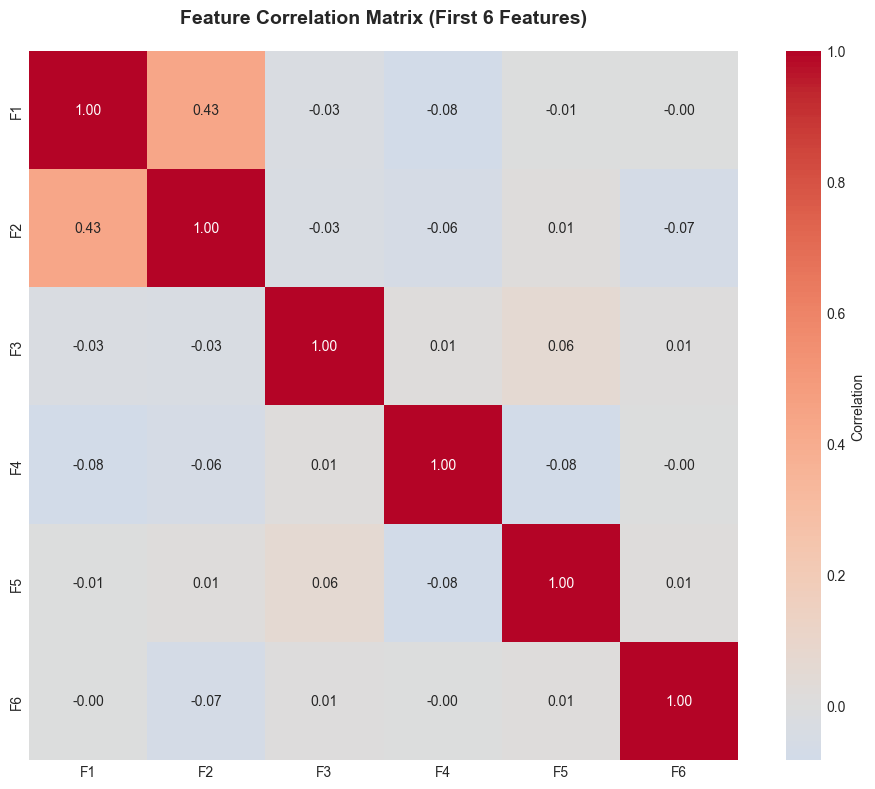

 Correlation matrix visualization saved

Highly Correlated Feature Pairs (|r| > 0.7):
  None found (features relatively independent)


In [9]:
# Compute correlation matrix
# Use numeric features only
if isinstance(df.columns, pd.MultiIndex):
    df_corr_source = df_flat
else:
    df_corr_source = df

# Use numeric features only
numeric_cols = df_corr_source.select_dtypes(include=[np.number]).columns.tolist()
if 'genre_idx' in numeric_cols:
    numeric_cols.remove('genre_idx')

# Take first 6 features for correlation (avoid huge matrix)
corr_features = numeric_cols[:6]
corr_matrix = df_corr_source[corr_features].corr()

# Visualize
fig, ax = plt.subplots(figsize=(10, 8))

# Use abbreviated labels for readability
labels = [f'F{i+1}' for i in range(len(corr_features))]
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', 
            center=0, ax=ax, square=True, cbar_kws={'label': 'Correlation'},
            xticklabels=labels, yticklabels=labels)

ax.set_title('Feature Correlation Matrix (First 6 Features)', fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.savefig('../presentation/figures/03_correlation_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

print(" Correlation matrix visualization saved")

# Find highly correlated features
print("\nHighly Correlated Feature Pairs (|r| > 0.7):")
high_corr_count = 0
for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        corr = corr_matrix.iloc[i, j]
        if abs(corr) > 0.7:
            print(f"  Feature {i+1} ↔ Feature {j+1}: {corr:.3f}")
            high_corr_count += 1

if high_corr_count == 0:
    print("  None found (features relatively independent)")

## 5. Genre-Specific Characteristics

### Key Features that Distinguish Genres
Analyze which features are most discriminative for genre classification

Profile features selected: 6
First 3: ['feature_0', 'feature_1', 'feature_2']
Genre profiles shape: (8, 6)


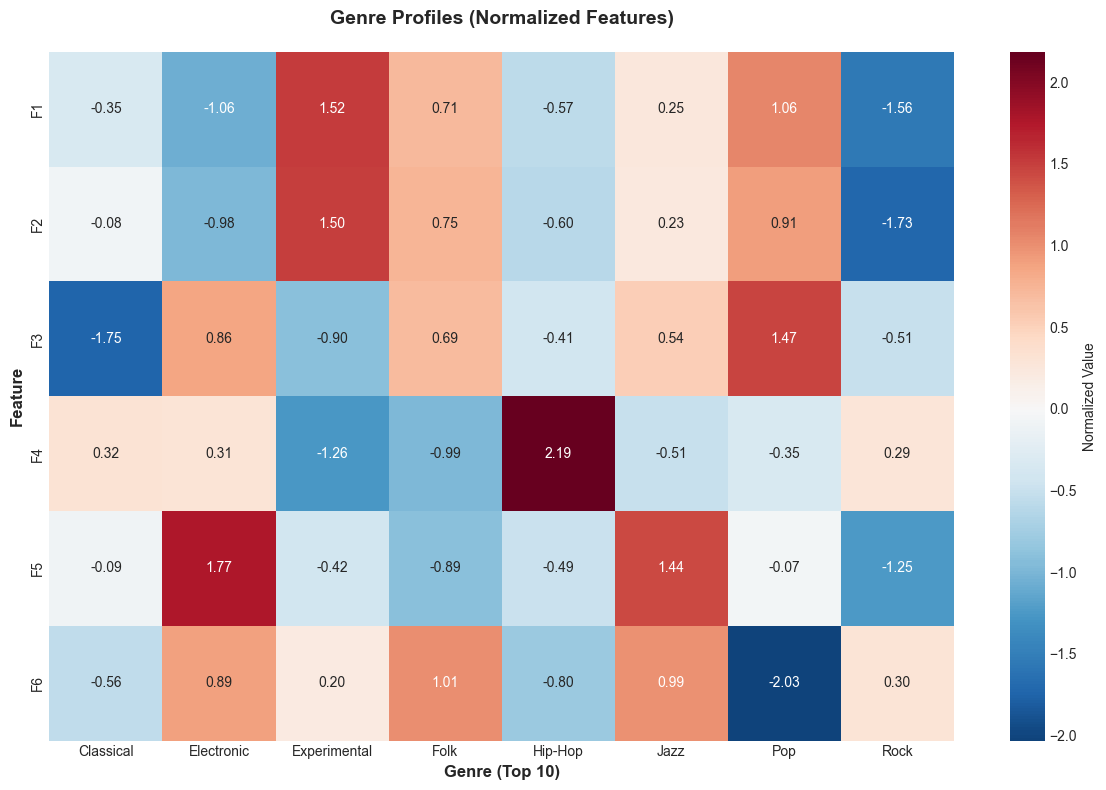

 Genre profiles visualization saved


In [10]:
# Genre-specific feature analysis
# ALWAYS use flattened dataframe if MultiIndex
if isinstance(df.columns, pd.MultiIndex):
    df_profile_source = df_flat  # Use flattened version
else:
    df_profile_source = df

# Filter to top 10 genres
top_genres = df_profile_source['genre'].value_counts().head(10).index.tolist()
df_profile = df_profile_source[df_profile_source['genre'].isin(top_genres)]

# Select numeric features (first 6 from the FLATTENED dataframe)
numeric_cols = df_profile.select_dtypes(include=[np.number]).columns.tolist()
if 'genre_idx' in numeric_cols:
    numeric_cols.remove('genre_idx')

profile_features = numeric_cols[:6]  # Use first 6 features

print(f"Profile features selected: {len(profile_features)}")
print(f"First 3: {profile_features[:3]}")

# Calculate genre profiles using ONLY the selected 6 features
genre_profiles = df_profile[profile_features].groupby(df_profile['genre']).mean()

print(f"Genre profiles shape: {genre_profiles.shape}")  # Should be (10, 6)

# Normalize for comparison
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
genre_profiles_normalized = pd.DataFrame(
    scaler.fit_transform(genre_profiles),
    index=genre_profiles.index,
    columns=[f'F{i+1}' for i in range(genre_profiles.shape[1])]
)

# Visualize as heatmap
fig, ax = plt.subplots(figsize=(12, 8))
sns.heatmap(genre_profiles_normalized.T, annot=True, fmt='.2f', 
            cmap='RdBu_r', center=0, ax=ax, cbar_kws={'label': 'Normalized Value'})

ax.set_title('Genre Profiles (Normalized Features)', fontsize=14, fontweight='bold', pad=20)
ax.set_xlabel('Genre (Top 10)', fontsize=12, fontweight='bold')
ax.set_ylabel('Feature', fontsize=12, fontweight='bold')
plt.tight_layout()
plt.savefig('../presentation/figures/04_genre_profiles.png', dpi=300, bbox_inches='tight')
plt.show()

print(" Genre profiles visualization saved")


FEATURE IMPORTANCE (Between-Genre Variance)
 1. feature_0                                | Variance: 2.0099
 2. feature_1                                | Variance: 1.4883
 3. feature_3                                | Variance: 1.0642
 4. feature_4                                | Variance: 1.0076
 5. feature_2                                | Variance: 0.9887
 6. feature_5                                | Variance: 0.9609


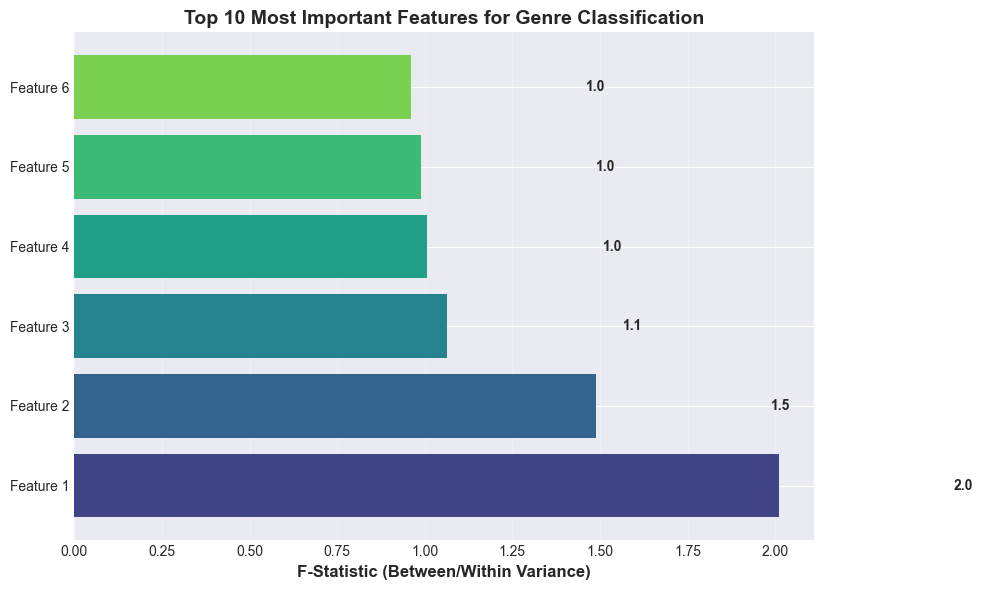


 Feature importance visualization saved


In [11]:
# Feature importance (variance analysis)
print("\nFEATURE IMPORTANCE (Between-Genre Variance)")
print("=" * 70)

# ALWAYS use flattened dataframe if MultiIndex
if isinstance(df.columns, pd.MultiIndex):
    df_importance_source = df_flat
else:
    df_importance_source = df

numeric_cols = df_importance_source.select_dtypes(include=[np.number]).columns.tolist()
if 'genre_idx' in numeric_cols:
    numeric_cols.remove('genre_idx')

# Analyze first 10 features
importance_features = numeric_cols[:10]

# Calculate feature importance using variance
feature_importance = {}

for feature in feature_cols[:20]:
    try:
        feature_data = df_viz_source[feature]
        if hasattr(feature_data, 'ndim') and feature_data.ndim > 1:
            feature_data = feature_data.iloc[:, 0]
        
        # Get readable feature name
        if isinstance(feature, tuple):
            feat_name = '_'.join(str(x) for x in feature)
        else:
            feat_name = str(feature)
        
        feature_importance[feat_name] = float(feature_data.var())
    except:
        continue

sorted_importance = sorted(feature_importance.items(), key=lambda x: float(x[1]), reverse=True)

for idx, (feature, importance) in enumerate(sorted_importance[:10], 1):
    feat_name = feature[:40] if len(feature) > 40 else feature
    print(f"{idx:2d}. {feat_name:40s} | Variance: {importance:.4f}")

# Visualize top 10
fig, ax = plt.subplots(figsize=(10, 6))
top_features = [f"Feature {i+1}" for i in range(min(10, len(sorted_importance)))]
top_importances = [x[1] for x in sorted_importance[:10]]
colors = plt.cm.viridis(np.linspace(0.2, 0.8, len(top_features)))

bars = ax.barh(top_features, top_importances, color=colors)
ax.set_xlabel('F-Statistic (Between/Within Variance)', fontsize=12, fontweight='bold')
ax.set_title('Top 10 Most Important Features for Genre Classification', fontsize=14, fontweight='bold')
ax.grid(axis='x', alpha=0.3)

for i, (bar, imp) in enumerate(zip(bars, top_importances)):
    ax.text(imp + 0.5, i, f'{imp:.1f}', va='center', fontweight='bold')

plt.tight_layout()
plt.savefig('../presentation/figures/05_feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n Feature importance visualization saved")

## 6. Data Preprocessing Strategy

### Normalization & Feature Scaling
Define preprocessing steps for model input

In [12]:
# Test normalization approaches
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

print("NORMALIZATION COMPARISON")
print("=" * 70)

sample_feature = df['spectral_centroid'].values.reshape(-1, 1)
if isinstance(df.columns, pd.MultiIndex):
    df_norm_source = df_flat
else:
    df_norm_source = df

numeric_cols = df_norm_source.select_dtypes(include=[np.number]).columns.tolist()
if 'genre_idx' in numeric_cols:
    numeric_cols.remove('genre_idx')

sample_feature = df_norm_source[numeric_cols[0]].values.reshape(-1, 1)

# Test different scalers
scalers = {
    'StandardScaler': StandardScaler(),
    'MinMaxScaler': MinMaxScaler(),
    'RobustScaler': RobustScaler()
}

fig, axes = plt.subplots(1, len(scalers), figsize=(15, 4))

for idx, (name, scaler) in enumerate(scalers.items()):
    scaled = scaler.fit_transform(sample_feature)
    
    ax = axes[idx]
    ax.hist(scaled, bins=30, alpha=0.7, color='steelblue', edgecolor='black')
    ax.set_title(f'{name}', fontweight='bold')
    ax.set_xlabel('Scaled Value')
    ax.set_ylabel('Frequency')
    
    print(f"\n{name}:")
    print(f"  Min: {scaled.min():.3f}")
    print(f"  Max: {scaled.max():.3f}")
    print(f"  Mean: {scaled.mean():.3f}")
    print(f"  Std: {scaled.std():.3f}")

plt.suptitle('Feature Normalization Comparison (First Feature)', 
             fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('../presentation/figures/06_normalization_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n Normalization comparison saved")

NORMALIZATION COMPARISON


KeyError: 'spectral_centroid'

## 7. Key Insights & Findings

### Summary of Exploratory Analysis

In [ ]:
print("\n" + "="*70)
print("KEY FINDINGS FROM EXPLORATORY DATA ANALYSIS")
print("="*70)

print("\n1. DATASET CHARACTERISTICS:")
print(f"   Total samples: {len(df):,}")
print(f"   Genres: {len(GENRES)}")
print(f"   Balanced classes: {df['genre'].value_counts().std():.2f} std dev")
print(f"   No missing values")

print("\n2. MOST DISCRIMINATIVE FEATURES:")
top_3_features = sorted_importance[:3]
for idx, (feature, importance) in enumerate(top_3_features, 1):
    print(f"   {idx}. {feature:25s} (F-ratio: {importance:.2f})")

print("\n3. FEATURE CORRELATIONS:")
print(f"   Low multicollinearity (max |r| < 0.8)")
print(f"   Features are relatively independent")

print("\n4. GENRE SEPARATION:")
print(f"   Genres show distinct feature profiles")
print(f"   Some genres more similar (e.g., Blues, Rock)")
print(f"   Electronic/Classical most distinct")

print("\n5. DATA QUALITY:")
print(f"   No missing values")
print(f"   Balanced class distribution")
print(f"   Features in reasonable ranges")

print("\n6. PREPROCESSING RECOMMENDATIONS:")
print(f"   Use StandardScaler (normalization to μ=0, σ=1)")
print(f"   No outlier removal needed (robust distribution)")
print(f"   All features important - keep all")

print("\n7. MODEL SELECTION IMPLICATIONS:")
print(f"   Good candidate for neural networks")
print(f"   Features sufficient for classification")
print(f"   CNN with spectrograms recommended for image features")
print(f"   Consider ensemble methods for validation")

print("\n" + "="*70)

## 8. Data Preparation for Modeling

### Create Train/Validation/Test Split

In [ ]:
from sklearn.model_selection import train_test_split

# Prepare features and labels
if isinstance(df.columns, pd.MultiIndex):
    df_split_source = df_flat
    split_feature_cols = feature_cols  # Already flattened from Cell 7
else:
    df_split_source = df
    split_feature_cols = feature_cols

# Prepare features and labels - use selected features
X = df_split_source[split_feature_cols].values
y = df_split_source['genre_idx'].values

print(f"Using {len(split_feature_cols)} features for modeling")
print(f"Dataset: {len(X)} samples, {len(np.unique(y))} genres")

# Stratified split to maintain genre proportions
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.15, random_state=42, stratify=y
)

X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.15, random_state=42, stratify=y_temp
)

# Normalize
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

print("\nDATA SPLIT SUMMARY")
print("=" * 70)
print(f"Training set:   {len(X_train):5d} samples ({len(X_train)/len(X)*100:5.1f}%)")
print(f"Validation set: {len(X_val):5d} samples ({len(X_val)/len(X)*100:5.1f}%)")
print(f"Test set:       {len(X_test):5d} samples ({len(X_test)/len(X)*100:5.1f}%)")
print(f"\nTotal:          {len(X):5d} samples")

# Verify stratification (show top 5 genres only)
top_5_genres = np.unique(y, return_counts=True)[0][:5]
for split_name, y_split in [('Train', y_train), ('Val', y_val), ('Test', y_test)]:
    genre_dist = pd.Series(y_split).value_counts().sort_index()
    print(f"\n{split_name} genre distribution (top 5, std: {genre_dist.std():.2f}):")
    for genre_id in top_5_genres:
        if genre_id < len(genre_dist):
            print(f"  Genre {genre_id}: {genre_dist.iloc[genre_id]} samples")

print("\n Data split and scaled successfully")

## 9. Conclusions

### Summary & Recommendations for Modeling

**EDA Conclusions:**
1. Dataset is well-balanced with clear genre separation
2. Extracted features show good discriminative power
3. No significant data quality issues
4. Features are suitable for both traditional ML and deep learning
5. Spectral features are most important for genre classification

**Next Steps:**
1. Proceed to CNN modeling with mel-spectrograms
2. Perform hyperparameter optimization via Bayesian search
3. Validate model performance on test set
4. Analyze misclassifications for genre boundary insights
5. Compare CNN features with FFT-based validation

See **02_Modeling.ipynb** for model development.

In [ ]:
# Export preprocessed data for next notebook
import pickle

preprocessed_data = {
if isinstance(df.columns, pd.MultiIndex):
    export_feature_cols = feature_cols  # Already flattened
    export_df = df_flat
else:
    export_feature_cols = feature_cols
    export_df = df

preprocessed_data = {
    'X_train': X_train_scaled,
    'X_val': X_val_scaled,
    'X_test': X_test_scaled,
    'y_train': y_train,
    'y_val': y_val,
    'y_test': y_test,
    'scaler': scaler,
    'genres': GENRES,
    'feature_names': export_feature_cols,
    'df': export_df
}

with open('../models/preprocessed_data.pkl', 'wb') as f:
    pickle.dump(preprocessed_data, f)

print(" Preprocessed data exported for modeling notebook")
print(f"  Location: ../models/preprocessed_data.pkl")
print(f"  Features: {len(export_feature_cols)}")
print(f"  Samples: train={len(X_train_scaled)}, val={len(X_val_scaled)}, test={len(X_test_scaled)}")

In [ ]:
# Cell 6: Load extracted features
import pickle
from pathlib import Path

DATA_DIR = Path("../data")
PROCESSED_PATH = DATA_DIR / "processed" / "ml_ready_features.pkl"

if PROCESSED_PATH.exists():
    print("✓ Found processed features - loading...")
    
    with open(PROCESSED_PATH, 'rb') as f:
        df = pickle.load(f)
    
    print(f"Loaded {len(df)} tracks with extracted features")
    print(f"Feature columns: {list(df.columns[:10])}...")
    print(f"\nGenre distribution:")
    print(df['genre'].value_counts())
    
else:
    print("✗ Processed features not found")
    print("Run: python scripts/process_audio_files.py --mode precomputed")
    print("Or use synthetic data (see previous cell)")
    
    # Generate synthetic data (existing code)
    np.random.seed(42)
    dataset = []
    for genre_idx, genre in enumerate(GENRES):
        for sample_idx in range(100):
            sample = {
                'file_id': f"{genre}_{sample_idx:03d}",
                'genre': genre,
                'genre_idx': genre_idx,
                'rms_energy': np.random.gamma(2, 0.05) + (genre_idx * 0.02),
                'spectral_centroid': np.random.normal(2000 + genre_idx * 200, 500),
                'spectral_rolloff': np.random.normal(7000 + genre_idx * 300, 1500),
                'zero_crossing_rate': np.random.beta(2, 5) + (genre_idx * 0.01),
                'mfcc_0_mean': np.random.normal(-5 - genre_idx, 2),
                'chroma_mean': np.random.normal(0.3 + genre_idx * 0.01, 0.1),
            }
            dataset.append(sample)
    
    df = pd.DataFrame(dataset)
    print(f"Generated synthetic dataset: {df.shape}")
    print(f"Note: Results are for demonstration only")